In [1]:
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
print('Parsing data from TSV files...')
start_time = time.time()
train_df = pd.read_csv('train.tsv', delimiter='\t', index_col=['train_id'])
X_test_df = pd.read_csv('test.tsv', delimiter='\t', index_col=['test_id'])
print(f'Done. Took {time.time() - start_time:.2f}s')

Parsing data from TSV files...


/Users/Marcus/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done. Took 8.71s


# Exploring data

## Data fields for reference:
(from kaggle competition)

The files consist of a list of product listings. These files are tab-delimited.
* train_id or test_id - the id of the listing
* <b>name</b> - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
* <b>item_condition_id</b> - the condition of the items provided by the seller, 1=Good,...,5=Poor
* <b>category_name</b> - category of the listing
* <b>brand_name</b>
* <b>price</b> - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
* <b>shipping</b> - 1 if shipping fee is paid by seller and 0 by buyer
* <b>item_description</b> - the full description of the item. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]

## Data exploration - visualization

Summary so far:
 * There are unique <b>4,810</b> brands.
 * There are <b>82,489</b> items with <b>"No description yet"</b>, around 6% of our dataset. (what you think)
 * There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
 * prices are skewed to the right.
 * top brands (PINK, Nike, Victoria's Secret, etc)
     * Note there are <b>632,682</b> items with no brand assigned ~ 43% of our training set!

In [3]:
# check data
train_df.head(5)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
# group by brands and check the most popular
brands = train_df.groupby(['brand_name']).size()

print('There are unique brands:', brands.shape[0])
print('{} entries have no brand assigned'.format(train_df[train_df['brand_name'].isnull()].shape[0]))

brands.sort_values(ascending=False).head(20)

There are unique brands: 4809
632682 entries have no brand assigned


brand_name
PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Adidas               10202
Funko                 9237
Under Armour          8461
Sony                  7994
Old Navy              7567
dtype: int64

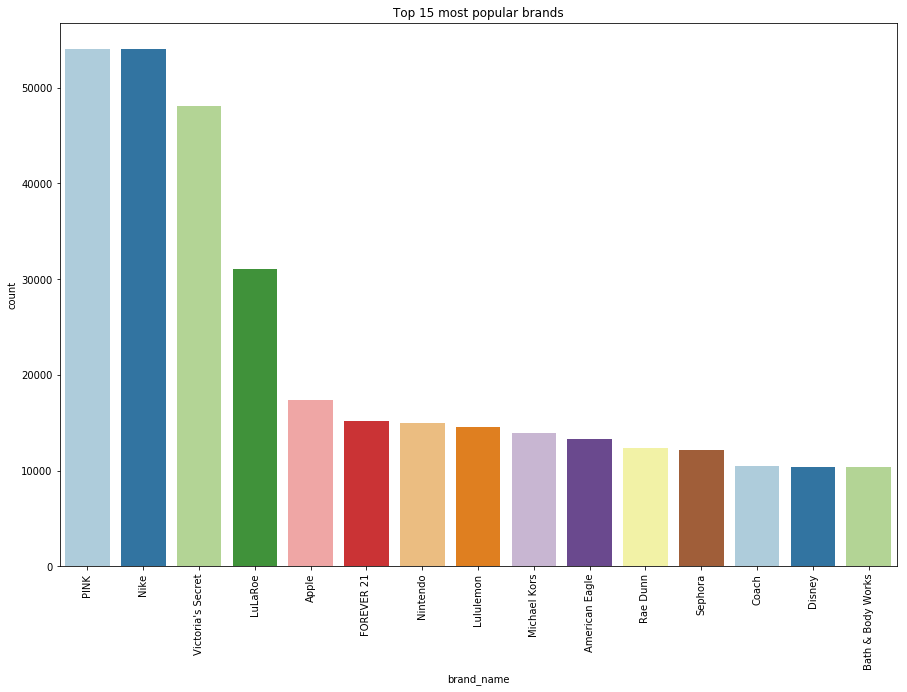

In [5]:
# Top 50 common brands
top_brands = train_df['brand_name'].value_counts()[0:15].reset_index()\
            .rename(columns={'index': 'brand_name', 'brand_name':'count'})

plt.figure(figsize=(15,10))
ax = sns.barplot(x="brand_name", y="count", data=top_brands, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# set title
ax.set_title('Top 15 most popular brands')
plt.show()

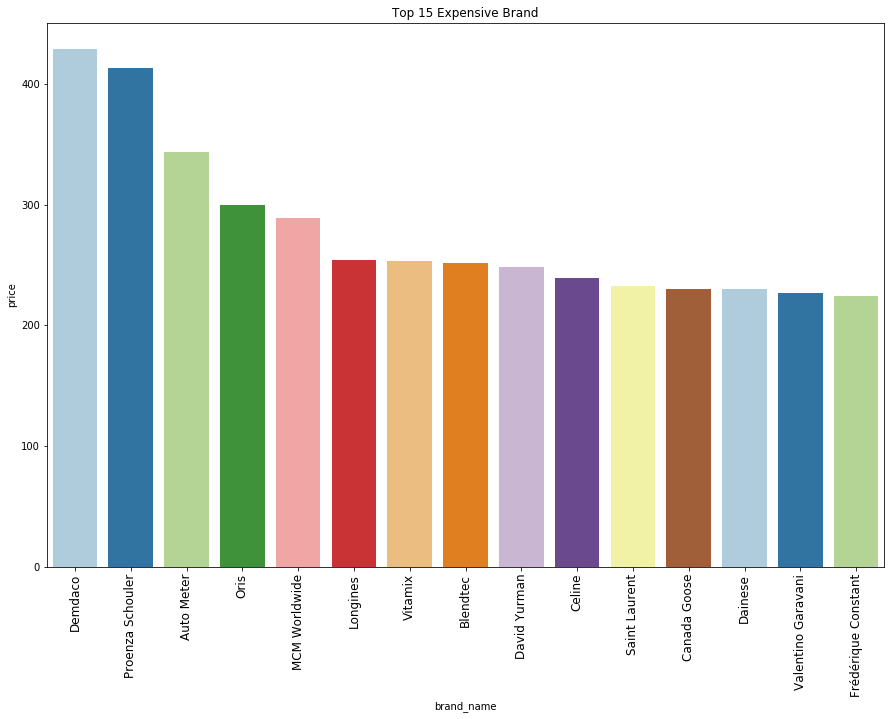

In [6]:
# Top 50 expensive brands
top_expensive = train_df.groupby('brand_name', axis=0).mean()
df_top_expensive = pd.DataFrame(top_expensive.sort_values('price', ascending = False)\
                                ['price'][0:15].reset_index())


plt.figure(figsize=(15, 10))
ax = sns.barplot(x="brand_name", y="price", data=df_top_expensive, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)

# set title
ax.set_title('Top 15 Expensive Brand')
plt.show()

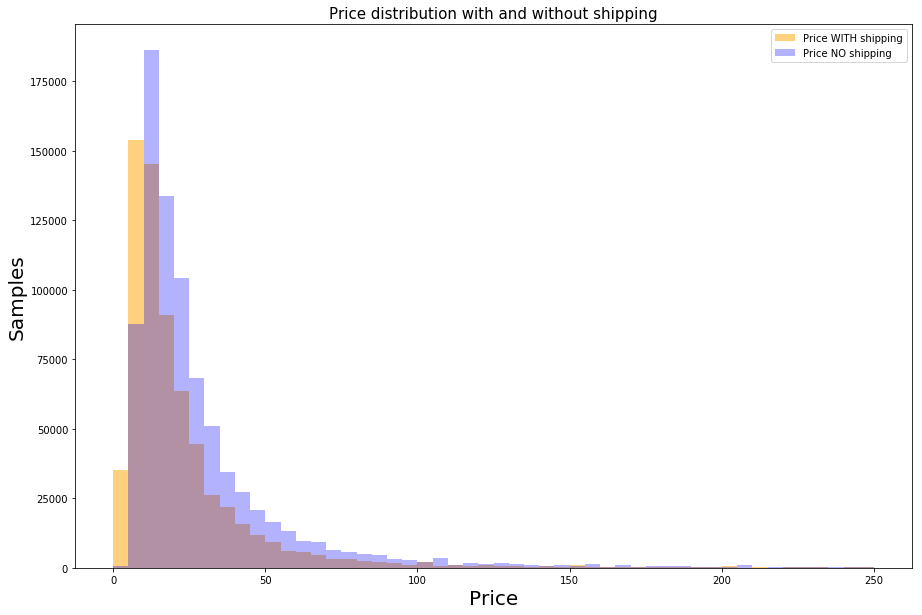

In [7]:
# price distribution for items with and without shipping
# items with no shipping tend to be a slightly more expensive

shipping = train_df[train_df['shipping']==1]['price']
no_shipping = train_df[train_df['shipping']==0]['price']

plt.figure(figsize=(15, 10))
plt.hist(shipping, bins=50, range=[0,250], alpha=0.5, label='Price WITH shipping', color='orange')
plt.hist(no_shipping, bins=50, range=[0,250], alpha=0.3, label='Price NO shipping', color='blue')
plt.title('Price distribution with and without shipping', fontsize=15)

plt.xlabel('Price', fontsize=20)
plt.ylabel('Samples', fontsize=20)
plt.legend()

plt.show()

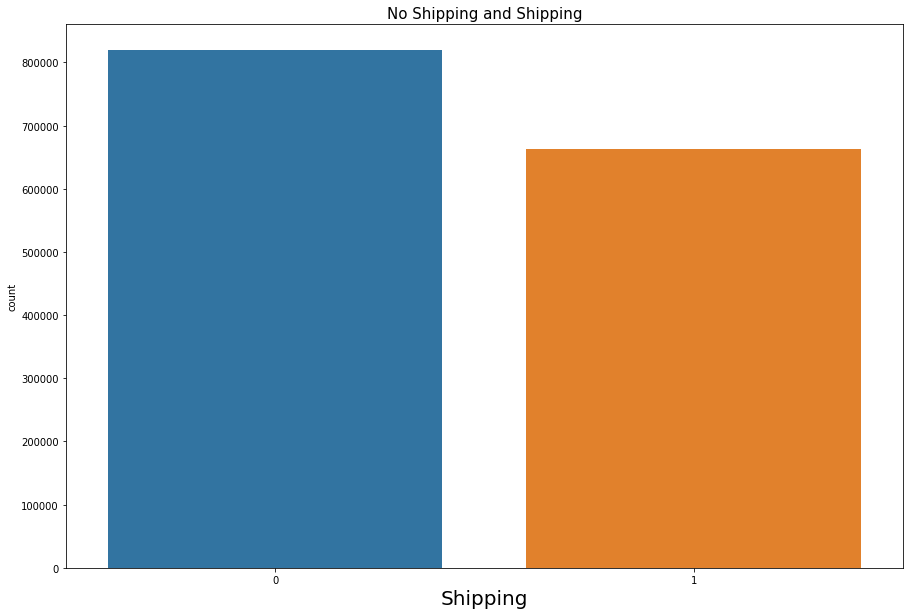

In [8]:
plt.figure(figsize=(15, 10))
plt.title('No Shipping and Shipping', fontsize=15)
sns.countplot(data=train_df, x='shipping')
plt.xlabel('Shipping', fontsize=20)

plt.show()

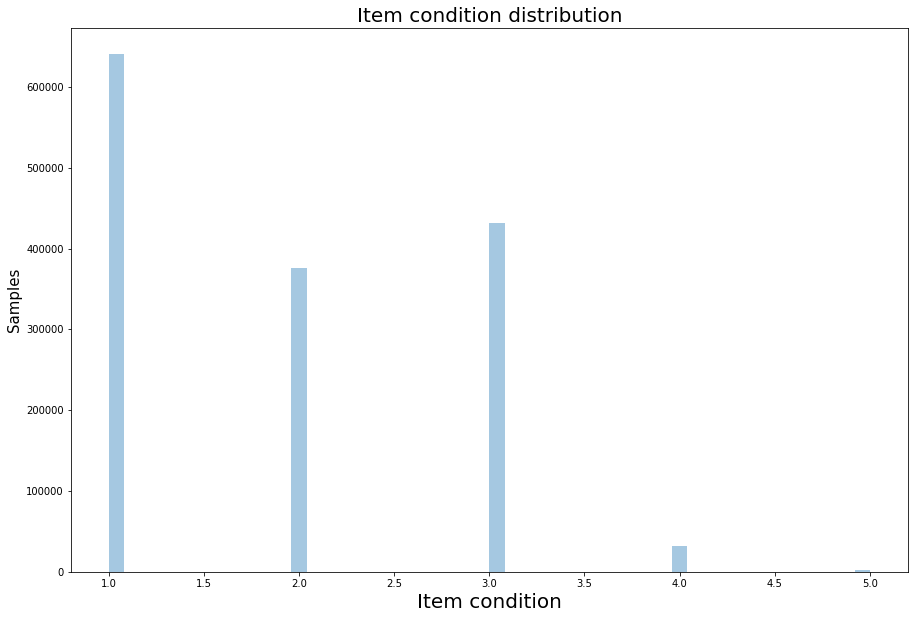

Condition 1 = 43.21%
Condition 2 = 25.33%
Condition 3 = 29.15%
Condition 4 = 2.16%
Condition 5 = 0.16%


In [9]:
# item condition distribution
# Most itmes are in good condition: 1,2 and 3
plt.figure(figsize=(15, 10))

ax = sns.distplot(train_df['item_condition_id'], kde=False)
plt.title('Item condition distribution', fontsize=20)
plt.xlabel('Item condition', fontsize=20)
plt.ylabel('Samples', fontsize=15)

plt.show()

# item condition percentages
for condition in range(1,6):
    items_count = len(train_df[train_df['item_condition_id'] == condition])
    percentage = round(items_count/len(train_df)*100, 2)
    print("Condition {} = {}%".format(condition, percentage))

In [10]:
# items with no description
no_description = train_df[train_df['item_description']=='No description yet']
print('There are {} items with no description'.format(no_description.shape[0]))

# select top 5
no_description.head(5)

There are 82489 items with no description


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,50.0,1,No description yet
90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,NaN,5.0,1,No description yet


<Figure size 1080x720 with 0 Axes>

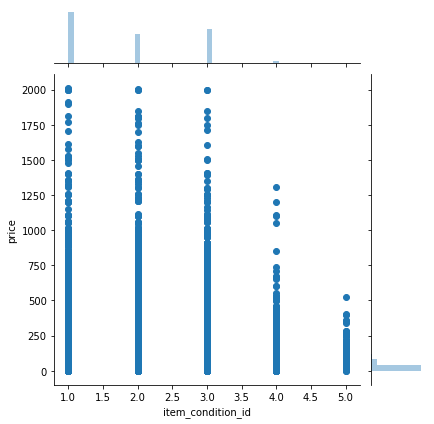

In [11]:
# looking for correlations between price and item condition
# expect to get higher price from items in condition = 1, cheaper as condition = 5
# there is not a very clear correlation other than bad (4,5) items tend to be cheaper

#log_price = df_train[['price', 'item_condition_id']]
#log_price['price'] = np.log1p(log_price['price'])

plt.figure(figsize=(15, 10))
sns.jointplot(x="item_condition_id", y="price", data=train_df)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

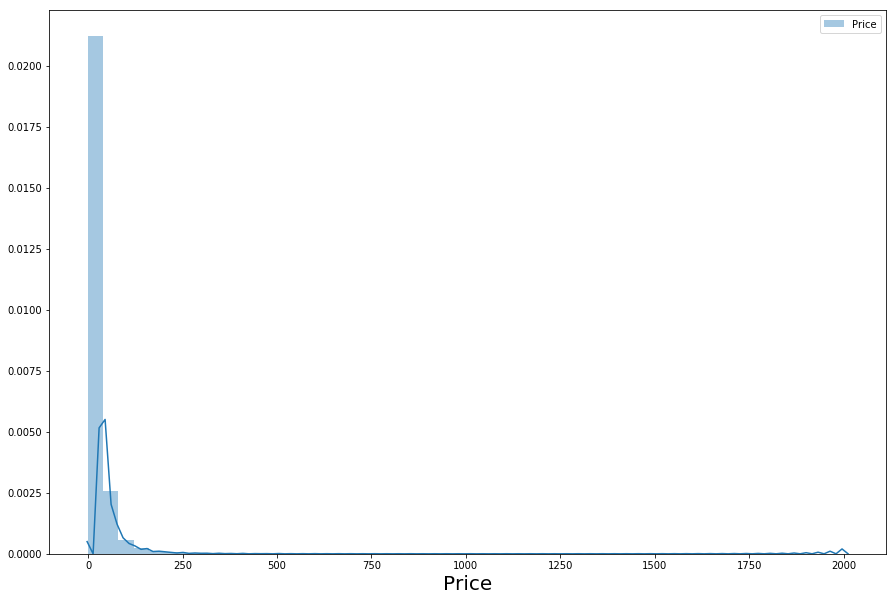

In [12]:
# Check prices, everything seems to be on the "cheaper side"
plt.figure(figsize=(15, 10))
ax = sns.distplot(train_df['price'], label='Price')
plt.xlabel('Price', fontsize=20)

plt.legend()
plt.show()

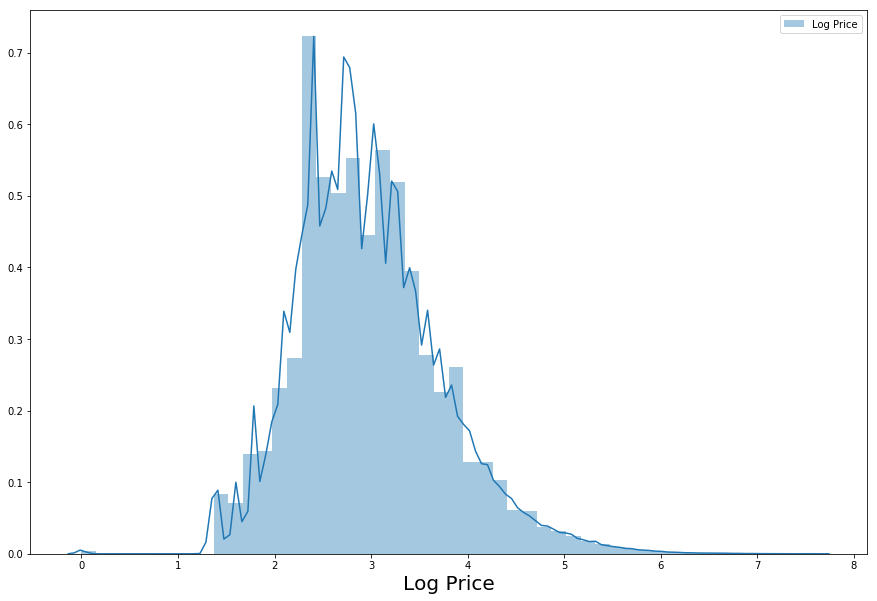

In [13]:
# Log price much better distribution
plt.figure(figsize=(15, 10))
ax = sns.distplot(np.log1p(train_df['price']), label='Log Price')
plt.xlabel('Log Price', fontsize=20)

plt.legend()
plt.show()

In [14]:
# price statistics
pd.set_option('float_format', '{0:.2f}'.format)
train_df['price'].describe()

count   1482535.00
mean         26.74
std          38.59
min           0.00
25%          10.00
50%          17.00
75%          29.00
max        2009.00
Name: price, dtype: float64

In [15]:
# log price statistics
pd.set_option('float_format', '{0:.2f}'.format)
log_prices = np.log1p(train_df['price'])
log_prices.describe()

count   1482535.00
mean          2.98
std           0.75
min           0.00
25%           2.40
50%           2.89
75%           3.40
max           7.61
Name: price, dtype: float64

In [16]:
train_df[train_df['price'] > 0].describe()

,item_condition_id,price,shipping
count,1481661.00,1481661.00,1481661.00
mean,1.91,26.75,0.45
std,0.90,38.59,0.50
min,1.00,3.00,0.00
25%,1.00,10.00,0.00
50%,2.00,17.00,0.00
75%,3.00,29.00,1.00
max,5.00,2009.00,1.00


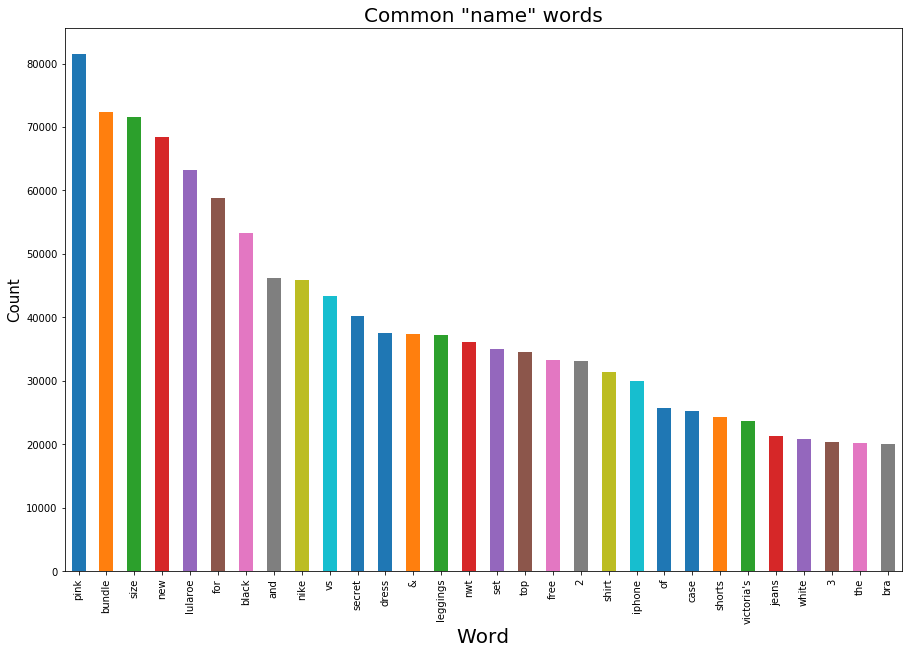

In [17]:
# display n common words for "name" column

top_n = 30
top_words = pd.Series(' '.join(train_df['name']).lower().split()).value_counts()[:top_n]

plt.figure(figsize=(15, 10))
top_words.plot.bar()
plt.title('Common "name" words', fontsize=20)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=15)

plt.show()

In [18]:
def catego_to_subcategos(category_name):
    """ this function will split the category into multiple sub categories """
    
    # try as some of the entries do not have 3 categories
    try:
        categories = category_name.split('/')
        return categories[:3]
    except:
        return np.nan,np.nan,np.nan

In [19]:
# spliting category into sub-categories
train_df['category1'],train_df['category2'],train_df['category3']=\
zip(*train_df['category_name'].apply(catego_to_subcategos))

In [20]:
# data split into sub categories
train_df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category1,category2,category3
train_id,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [21]:
# Count of category lengths
num_categories_dict = defaultdict(int)
for i, category in enumerate(train_df['category_name']):
    if type(category) != str:
        num_categories_dict['null'] += 1
        continue
    else:
        categories = category.split('/')
        num_categories = len(categories)
        num_categories_dict[num_categories] += 1
        
for k, v in num_categories_dict.items():
    print(f'Number of entries with {k} categories: {v}')
    
print('Unique categories 1:', len(train_df['category1'].unique()))
print('Unique categories 2:', len(train_df['category2'].unique()))
print('Unique categories 3:', len(train_df['category3'].unique()))
print()

Number of entries with 3 categories: 1471819
Number of entries with null categories: 6327
Number of entries with 5 categories: 3059
Number of entries with 4 categories: 1330
Unique categories 1: 11
Unique categories 2: 114
Unique categories 3: 871



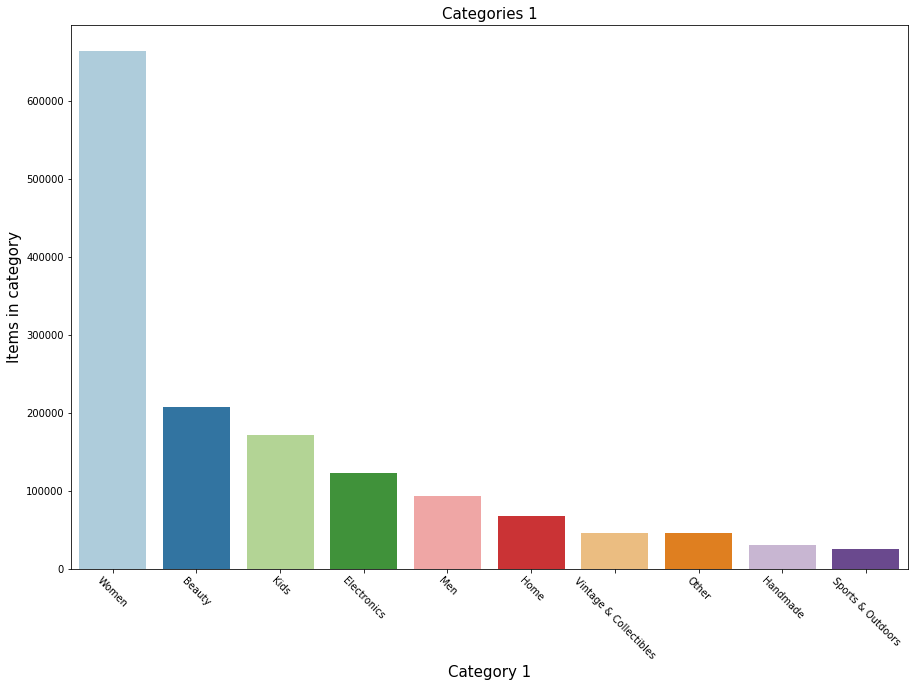

Men: 6.32%
Electronics: 8.28%
Women: 44.81%
Home: 4.58%
Sports & Outdoors: 1.71%
Vintage & Collectibles: 3.14%
Beauty: 14.02%
Other: 3.06%
Kids: 11.58%
nan: 0.0%
Handmade: 2.08%


In [22]:
# There is a total of 10 category 1
plt.figure(figsize=(15, 10))
x = train_df['category1']
y = train_df['category1'].value_counts().index

sns.countplot(x, order=y, palette='Paired')

plt.title('Categories 1', fontsize=15)
plt.xlabel('Category 1', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()


for category in train_df['category1'].unique():
    items_count = len(train_df[train_df['category1'] == category])
    percentage = round(items_count/len(train_df)*100, 2)
    print("{}: {}%".format(category, percentage))

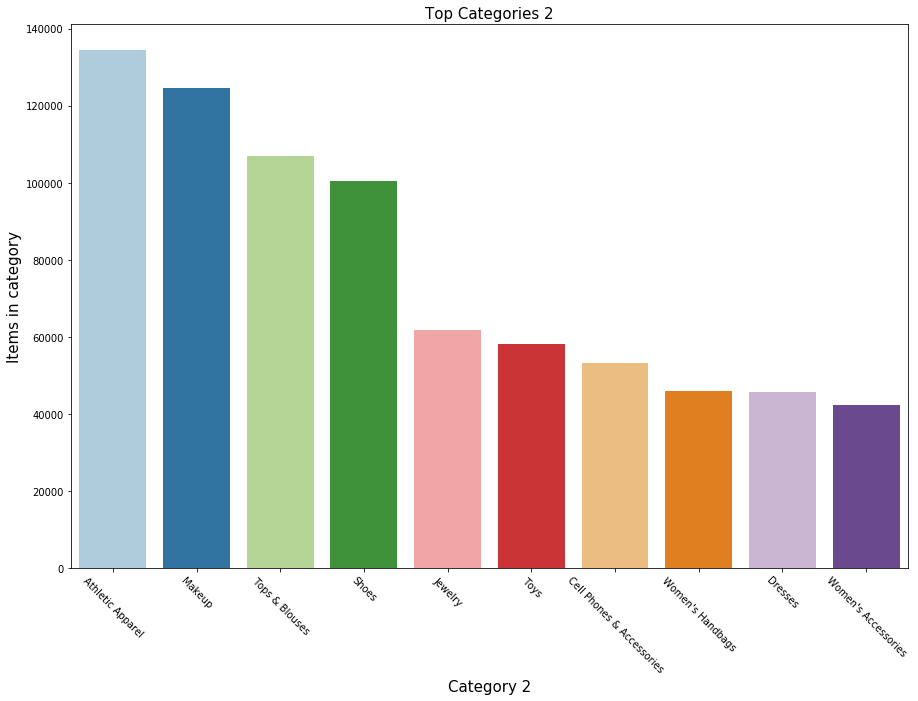

In [23]:
# plot category 2  
plt.figure(figsize=(15, 10))
x = train_df['category2']
y = train_df['category2'].value_counts().index[:10]

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories 2', fontsize=15)
plt.xlabel('Category 2', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()

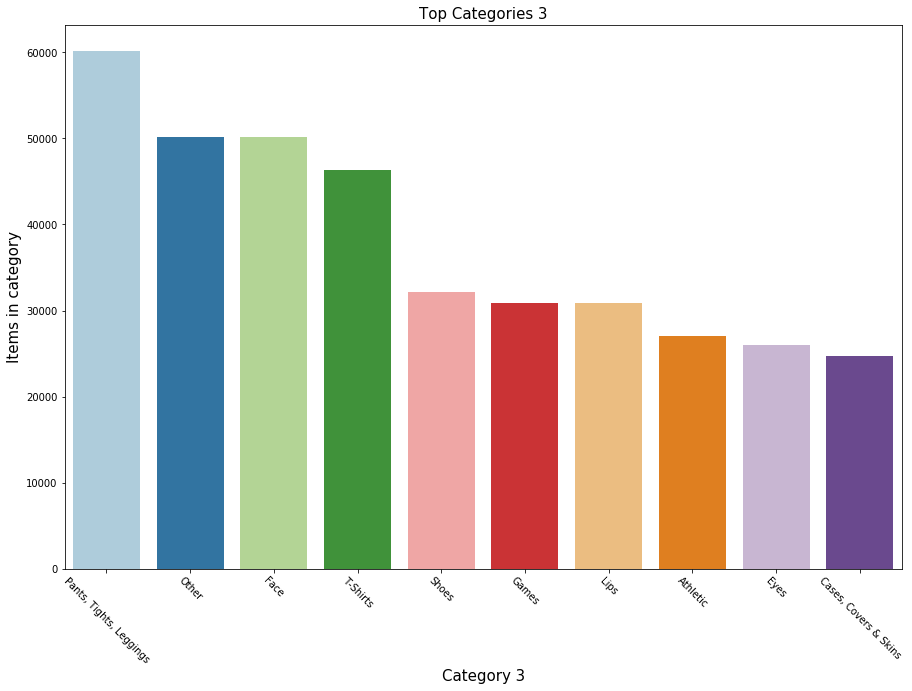

In [24]:
# plot category 3
plt.figure(figsize=(15, 10))
x = train_df['category3']
y = train_df['category3'].value_counts().index[:10]

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories 3', fontsize=15)
plt.xlabel('Category 3', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()